In [1]:
import json
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from utils import *

plt.rcParams['figure.figsize'] = [7, 10]


In [2]:
with open('./data/2022_3-2output.json', 'r') as f:
    ocroutj = json.load(f)

ocroutj.sort(key=lambda x: x['context']['pageNumber'])

# implementation

In [3]:
startPage = 16

In [4]:
# BaseLines = [None for _ in range(len(ocroutj))]
pages = [None for _ in range(len(ocroutj))]

pagesLines = [None for _ in range(len(ocroutj))]

for ii in trange(len(ocroutj)):
    # if the page is empty
    if 'fullTextAnnotation' not in ocroutj[ii].keys(): continue

    fullTextAnnote = ocroutj[ii]['fullTextAnnotation']['pages'][0]
    pageNumber = ocroutj[ii]['context']['pageNumber']
    
    cBlock, AllBaseLine = getBlock(fullTextAnnote['blocks'])

    pages[ii] = cBlock
    # BaseLines[ii] = np.array(AllBaseLine)
    _linesInPage = lineInPage(cBlock, np.array(AllBaseLine))
    _linesInPage.update({'toc': False, 'interested': False})

    pagesLines[pageNumber-1] = _linesInPage

100%|██████████| 544/544 [00:06<00:00, 89.63it/s] 


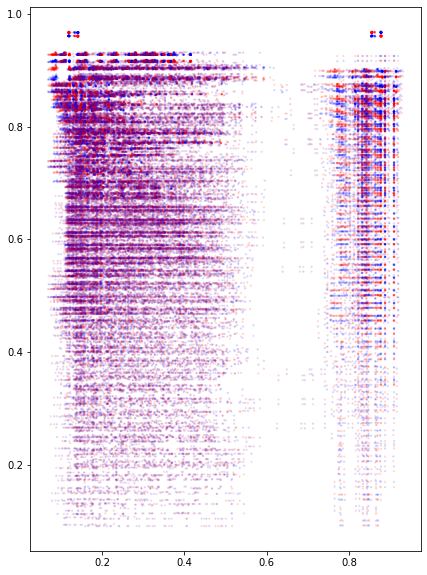

In [5]:
interestedPage = [23, 25, 27, 31, 33, 43, 47, 50, 52, 55, 57, 67, 69, 71, 73, 76, 78, 80, 89, 95, 96, 100, 
                  102, 111, 114, 116, 119, 121, 131, 133, 135, 137, 139, 142, 144, 154, 159, 161, 163, 166, 
                  168, 170, 178, 180, 182, 184, 186, 189, 191, 202, 205, 207, 210, 212, 221, 223, 227, 229, 
                  232, 234, 236, 245, 250, 252, 254, 256, 259, 261, 270, 272, 274, 275, 278, 287, 292, 294, 
                  297, 299, 301, 311, 315, 318, 320, 331, 333, 336, 338, 340, 342, 345, 347, 349, 351, 353, 
                  355, 365, 370, 372, 375, 378, 380, 389, 393, 395, 397, 400, 402, 411, 413, 416, 418, 420, 
                  423, 425, 427, 437, 440, 442, 443, 446, 448, 450, 459, 461, 462, 464, 466, 469, 471, 473, 
                  484, 490, 493, 495, 497, 507, 510, 512, 515, 518, 520, 529, 531, 533, 535, 538, 540]
                  
vxs = []
vys = []
colors = []
for ii in interestedPage:
  if not pages[ii]: continue
  for block in pages[ii]:
    for v, c in zip(block['normalizedVertices'], 'rbrb'):
      vx, vy = v
      vxs.append(vx);vys.append(1-vy)
      colors.append(c)


plt.scatter(vxs, vys, c=colors, s=2, alpha=.1)

In [6]:
# Table of contents
units = []
for ii in range(3,16):
  # only interested in 7. รายละเอียดงบประมาณจำแนกตามแผนงาน และ ผลผลิต/โครงการ
  _unit = {}
  if pagesLines[ii] == None: continue
  
  for line in pagesLines[ii]['lines']:
    bullet = get_patern_of_bullet(line['text'].split(' ')[0])

    if bullet and bullet[1] == 50:
      _unit.update({'id': len(units), 'unit_name': line['text']})
    elif 'unit_name' in _unit.keys() and line['text'].startswith('7. รายละ'):
      _unit.update({'start': int(line['blocks'][-1]['text'])+startPage-1})
    elif 'start' in _unit.keys():
      _unit.update({'end': int(line['blocks'][-1]['text'])+startPage-1})
      units.append(_unit)
      _unit = {}
    else: continue
    pagesLines[ii]['toc'] = True

In [7]:
def interested(textInpage):
  if 'วัตถุประสงค์' in textInpage or\
     'เงินงบประมาณ' in textInpage:
     return False
  return True

In [8]:
for unit in units:
  for pageidx in range(unit['start'], unit['end']):
    # print(pageidx-startPage+1, pagesLines[pageidx]['text'])
    if (interested(pagesLines[pageidx]['text'])):
      pagesLines[pageidx]['interested'] = True

In [9]:
with open('./output/pagesLines.json', 'w') as f:
  json.dump(pagesLines, f, ensure_ascii=False)
with open('./output/units.json', 'w') as f:
  json.dump(units, f, ensure_ascii=False)